In [1]:
cd ../../src

/home/kuba/Projects/notebooks/examples-counterexamples/src


In [2]:
from __future__ import print_function

import logging

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from fetch_mnist import preprocessed_mnist

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
category_count = len(np.unique(y_train))

def data_iter(X, y, batch_size=5000):
  return mx.io.NDArrayIter(
    data=nd.array(X),
    label=nd.array(y),
    batch_size=batch_size)

train_iter = data_iter(X_train, y_train)
valid_iter = data_iter(X_valid, y_valid)
test_iter = data_iter(X_test, y_test)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Logistic regression with softmax using `module` API

In [4]:
data = sym.Variable('data')
hid = sym.FullyConnected(data, name='hidden', num_hidden=category_count)
out = sym.SoftmaxOutput(hid, name='softmax')

nn = mod.Module(symbol=out)

In [12]:
"""
This is suggested in 
https://github.com/apache/incubator-mxnet/issues/798
"""

def log_to_list(period, lst, print_log=False):
    def _callback(param):
        """The checkpoint function."""
        if param.nbatch % period == 0 and param.eval_metric is not None:
            name_value = param.eval_metric.get_name_value()
            for name, value in name_value:
                message_args = (param.epoch, param.nbatch, name, value)
                message = 'Iter[{}] Batch[{}] Train-{}={}'.format(*message_args)
                if print_log:
                  print(message)
                lsb.append(message, message_args)
    return _callback

In [7]:
log_list = []
%time nn.fit(\
  train_iter,\
  eval_data=valid_iter,\
  batch_end_callback=log_to_list(5, log_list),\
  num_epoch=50)

CPU times: user 24.4 s, sys: 844 ms, total: 25.3 s
Wall time: 12.2 s


In [8]:
y_test_pred_proba = nn.predict(test_iter)
y_test_pred = nd.argmax(y_test_pred_proba, axis=1)

In [9]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred.asnumpy())

0.89400000000000002

In [14]:
accs = [msg[1][3] for msg in log_list]

#### TODO: is this train or validation metric? 

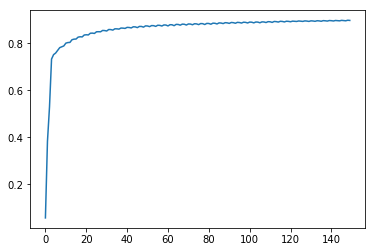

In [19]:
plt.plot(np.arange(50 * 3), accs)